# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an flow model and run it on one to two datasets. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
# !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 309 (delta 87), reused 114 (delta 35), pack-reused 99
Receiving objects: 100% (309/309), 50.42 MiB | 24.31 MiB/s, done.
Resolving deltas: 100% (124/124), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=6773 sha256=560bf08932b53aee9531ee6470c2b676a585b143cc55aa672b6a0ed563cee938
  Stored in directory: /tmp/pip-ephem-wheel-cache-g3eofzm8/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul
  Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [0]:
from deepul.hw2_helper import *

# Question 1: 2D Data

In this question, we will train two variants of flow models on continuous 2D data. 

Execute the cell below to visualize our datasets

Dataset 1


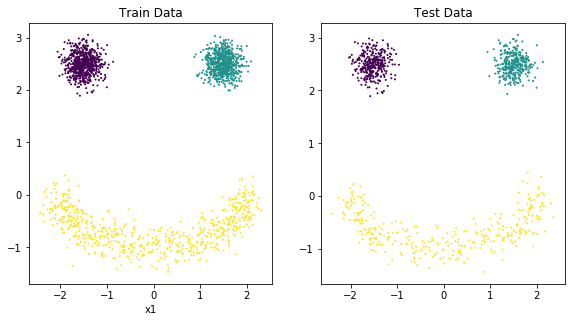

Dataset 2


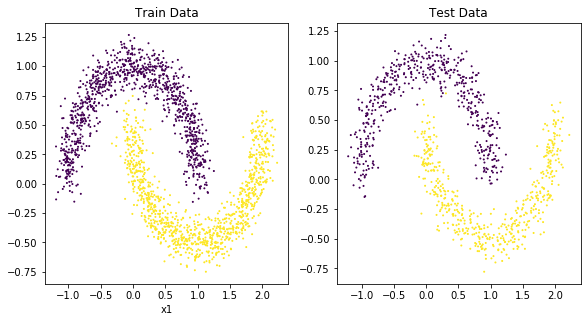

In [3]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Autoregressive Flow

In an autoregressive flow, we learn the transformation $z_i = f(x_i | x_{1:i-1})$. The log-likelihood is then $\log p_\theta(x) = \sum_{i=1}^d p(z_i) + log |\frac{dz_i}{dx_i}|$ because the Jacobian is triangular. For each dimension, use the CDF of a mixture of Gaussians or Logistics to map to the latent space, which should be $z_i \sim \text{Unif}[0, 1]$ i.i.d..

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set. Since this is a 2D problem, you can either learn $z_0 = f(x_0)$ and $z_1 = f(x_1; x_0)$ together with a MADE model, or with separate networks. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [4]:
!pip install ipdb

  Created wheel for ipdb: filename=ipdb-0.12.3-cp36-none-any.whl size=9225 sha256=6a1b86b118e2b0763594612923e8a90b45b03a404c1adf109281c1855c82c010
  Stored in directory: /root/.cache/pip/wheels/57/43/c5/614153606de8f5e358e266723f53254e70752f4ffc8c85ec63
Successfully built ipdb


In [0]:
import deepul.pytorch_util as ptu
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import trange, tqdm_notebook

def train(model, data_loader, optimizer):
    model.train()
    losses = []
    for x in data_loader:
        x = x.to(ptu.device).float().contiguous()
        loss = model.nll(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(ptu.device).float().contiguous()
            loss = model.nll(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)  # loss at init
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        model.train()
        epoch_train_losses = train(model, train_loader, optimizer) 
        train_losses.extend(epoch_train_losses)

        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
            
    return train_losses, test_losses

In [0]:
import copy
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from scipy.stats import norm

class MixtureCDFFlow(nn.Module):
    def __init__(self, 
                 base_dist='uniform', 
                 mixture_dist='gaussian',
                 n_components=4,
                 plot_bounds=(-3,3)):
        super().__init__()
        self.composition = False
        if base_dist == 'uniform':
            self.base_dist = Uniform(0.0, 1.0)
        else:
            raise NotImplementedError

        self.loc = nn.Parameter(torch.randn(n_components), requires_grad=True)
        self.log_scale = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.weight_logits = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        if mixture_dist == 'gaussian':
            self.mixture_dist = Normal
        elif mixture_dist == 'logistic':
            raise NotImplementedError
        self.n_components = n_components
        self.plot_bounds = plot_bounds

    def flow(self, x):
        # z = cdf of x
        weights = F.softmax(self.weight_logits, dim=0).unsqueeze(0).repeat(x.shape[0], 1)
        z = (self.mixture_dist(self.loc, self.log_scale.exp()).cdf(x.unsqueeze(1).repeat(1, self.n_components)) * weights).sum(dim=1)

        # log_det = log dz/dx = log pdf(x)
        log_det = (self.mixture_dist(self.loc, self.log_scale.exp()).log_prob(x.unsqueeze(1).repeat(1, self.n_components)).exp() * weights).sum(dim=1).log()

        return z, log_det

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return self.base_dist.log_prob(z) + log_det
 
    # Compute loss as negative log-likelihood
    def nll(self, x):
        return - self.log_prob(x).mean()

class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        super().__init__()
        layers = []
        for _ in range(n_hidden):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

class AutoregressiveFlow(nn.Module):
    """
    Assumes that we're modeling a 2D distribution
    """
    def __init__(self, 
                 dim1_mixture_dist='gaussian', 
                 dim1_n_components=5, 
                 dim2_mixture_dist='gaussian', 
                 dim2_n_components=5,
                 mlp_hidden_size=64,
                 mlp_n_layers=3):
        super().__init__()
        self.dim1_flow = MixtureCDFFlow(mixture_dist=dim1_mixture_dist, n_components=dim1_n_components)
        self.mlp = MLP(1, mlp_n_layers, mlp_hidden_size, dim2_n_components * 3)
        self.dim2_n_components = dim2_n_components
        self.base_dist = Uniform(ptu.tensor(0.0), ptu.tensor(1.0))
        if dim2_mixture_dist == 'gaussian':
            self.mixture_dist = Normal
        elif dim2_mixture_dist == 'logistic':
            raise NotImplementedError

    def flow(self, x):
        # individually flow on each dim
        x1, x2 = torch.chunk(x, 2, dim=1)
        # dim 1 
        z1, log_det1 = self.dim1_flow.flow(x1.squeeze())
        
        # dim1
        loc, log_scale, weight_logits = torch.chunk(self.mlp(x1), 3, dim=1)
        weights = F.softmax(weight_logits, dim=1)
        z2 = (self.mixture_dist(loc, log_scale.exp()).cdf(
            x2.repeat(1, self.dim2_n_components)) * weights).sum(dim=1)
        log_det2 = (self.mixture_dist(loc, log_scale.exp()).log_prob(
            x2.repeat(1, self.dim2_n_components)).exp() * weights).sum(dim=1).log()
        return torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1), torch.cat([log_det1.unsqueeze(1), log_det2.unsqueeze(1)], dim=1)

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return (self.base_dist.log_prob(z) + log_det).sum(dim=1) # shape: [batch_size, dim]

    def nll(self, x):
        return - self.log_prob(x).mean()

In [0]:
def q1_a(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats in R^2
  test_data: An (n_test, 2) numpy array of floats in R^2
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
  - a numpy array of size (n_test, 2) of floats in [0,1]^2. This represents 
      mapping the test set data points through our flow to the latent space. 
  """
  
  """ YOUR CODE HERE """
  # create data loaders
  # train_dset, test_dset = NumpyDataset(train_data), NumpyDataset(test_data)
  print(train_data[:2], train_data.shape, test_data[:2], test_data.shape)
  loader_args = dict(batch_size=128, shuffle=True)
  training_loader = data.DataLoader(train_data, **loader_args), 
  test_loader = data.DataLoader(test_data, **loader_args)

  # model
  ar_flow = AutoregressiveFlow()

  # train
  train_losses, test_losses = train_epochs(ar_flow, training_loader, test_loader, dict(epochs=100, lr=5e-3))

  # heatmap
  dx, dy = 0.025, 0.025
  if dset_id == 1:  # face
      x_lim = (-4, 4)
      y_lim = (-4, 4)
  elif dset_id == 2:  # two moons
      x_lim = (-1.5, 2.5)
      y_lim = (-1, 1.5)
  y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
  mesh_xs = ptu.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
  densities = np.exp(ptu.get_numpy(ar_flow.log_prob(mesh_xs)))

  # latents
  z, _ = ar_flow.flow(ptu.FloatTensor(test_data))
  latents = ptu.get_numpy(z)

  return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



In [46]:
q1_save_results(1, 'a', q1_a)

[[-1.67045253 -0.58035858]
 [-1.4910252  -0.97832866]] (1998, 2) [[-1.70971059  2.21599641]
 [-1.14718953  2.58003144]] (999, 2)
4.9401960372924805


AttributeError: ignored

In [0]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = d-1$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [0]:
def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Final Test Loss: 2.0586


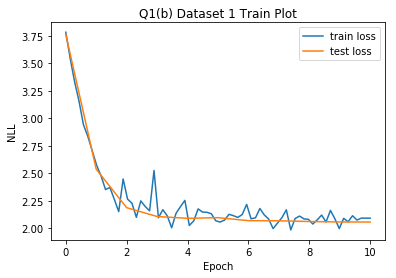

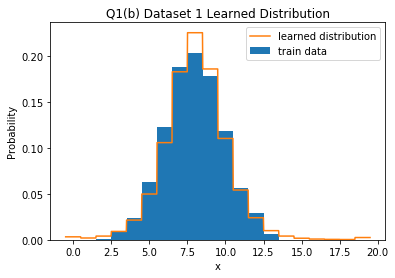

In [0]:
q1_save_results(1, 'b', q1_b)

In [0]:
q1_save_results(2, 'b', q1_b)

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

In [0]:
visualize_q2a_data(dset_type=1)
visualize_q2a_data(dset_type=2)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [0]:
def q2_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for each random variable x1 and x2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d, d) of probabilities (the learned joint distribution)
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Final Test Loss: 3.1518


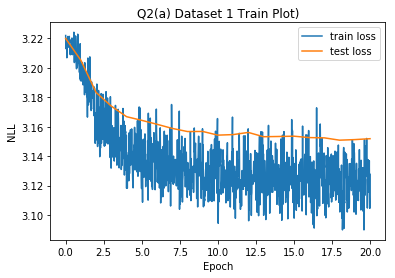

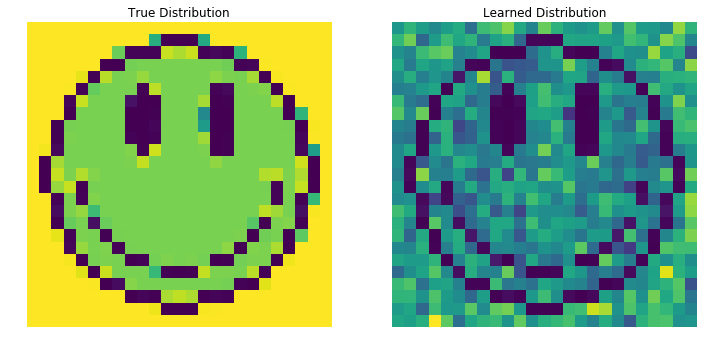

In [0]:
q2_save_results(1, 'a', q2_a)

In [0]:
q2_save_results(2, 'a', q2_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

In [0]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [0]:
def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Final Test Loss: 0.0623


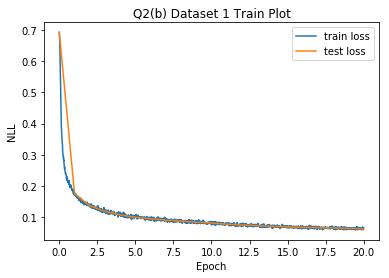

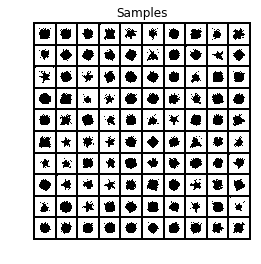

In [0]:
q2_save_results(1, 'b', q2_b)

In [0]:
q2_save_results(2, 'b', q2_b)

# Question 3 Flows on Higher Dimensions


Now, you will train more powerful PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling colored datasets with and without channel conditioning.



## Part (a) RealNVP
- insert architecture
- insert the training hyperparameters
- insert a description of what's going on 


In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [0]:
def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



Final Test Loss: 0.0420


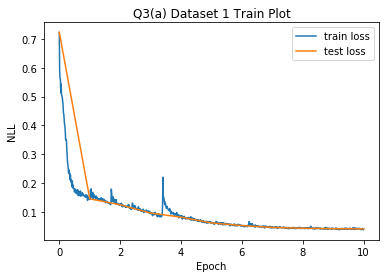

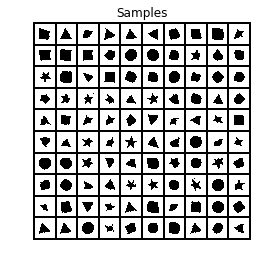

In [0]:
q3a_save_results(1, q3_a)

In [0]:
q3a_save_results(2, q3_a)

# Question 4: Bonus Questions (Optional)

## Q4(a): Multiscale RealNVP
Following the alternating checkerboard, channel squeeze, and channel partition scheme used in https://arxiv.org/abs/1605.08803, learn a multiscale RealNVP model on our CelebA dataset used in Question 3. We expect the same deliverables as in Question 3; additionally, make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [0]:
q4a_save_results(2, q4_a)

## Q4(b): Glow
The Glow paper introduces the invertible 1x1 convolution as a replacement for the permutation scheme that follows the channel squeezing step. Use this in your model from Question 3, and report the same deliverables. Make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [0]:
q4b_save_results(2, q4_b)